# Tutorial 3 - Interventions

- [Go back to **Tutorial 2: Handling PyRossGeo output**](../tutorial2-handling-PyRossGeo-output/tutorial2-handling-PyRossGeo-output.ipynb)
- [Skip to **Tutorial 4: Making visualisations using GeoPandas**](../tutorial4-making-visualisations-with-geopandas/tutorial4-making-visualisations-using-geopandas.ipynb)
- [Go to the PyRossGeo documentation](https://github.com/lukastk/PyRossGeo/blob/master/docs/documentation.md)

In this tutorial we will learn how to model a lock-down using *events*.

In [3]:
# Compile and import local pyrossgeo module
import os, sys
owd = os.getcwd()
os.chdir('../../')
sys.path.insert(0,'../../')
!python setup.py build_ext --inplace
os.chdir(owd)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyrossgeo

import pandas as pd
import json

running build_ext


## 2.1 Generating simulation data

We will start by generating some simulation data. We have our config files in the folder `SEAIR_network`, which sets up a network with 10 locations with commuting edges between them.

Run the simulation

In [4]:
ts, dts = pyrossgeo.utils.get_dt_schedule([
    (0,  2*60),    
    (7*60,  1),    
    (9*60, 2*60),  
    (17*60, 1),     
    (19*60, 2*60)  
], end_time=24*60)

t_start = 0
t_end = 24*60*400 # Run for 200 days

sim = pyrossgeo.Simulation()
X_state = sim.initialize(sim_config_path='SEAIR_network')

sim_data = sim.simulate(X_state, t_start, t_end, dts, steps_per_save=1)

In `pyrossgeo.Simulation.simulate`, we have passed the optional argument `steps_per_save=1`. This means that the method will return simulation data for every forward-Euler in the simulation. If we instead set, `steps_per_save=len(dts)`, we will get one data point for every day.

For large networks the output can grow very large. One way to decrease the size of the output is by only saving node data, and discarding commuter node data. To enable this option, pass `only_save_nodes=True` to the method.

## 2.2 The raw simulation output: `sim_data`

We will now look at the contents of the simulation output `sim_data`.

In [5]:
state_mappings, ts_saved, X_states_saved = sim_data
node_mappings, cnode_mappings = state_mappings

`ts_saved` is a 1D array containing the times of every state saved during the simulation. As we specified `steps_per_save=1` in the simulation, `ts_saved` comprises all the simulated time steps.

`X_states_saved` is a numpy array with `len(ts_saved)` rows and a column for each degree of freedom of the system. The total number of degrees of freedom of the system is

$$
\text{model dimension} \times ( \text{no. of nodes} + \text{no. of commuter nodes} ).
$$

In our case the model dimension is 5 (SEAIR), and we have 41 nodes and 22 commuter nodes, which makes up a total of 315 degrees of freedom.

`node_mappings` is a dictionary that maps each node to its corresponding index in the system state vector. Each key in the dictionary is a tuple of the form `(age, model_class, home, location)`. For example, we could use `node_mappings` to get the data of the $I$ class of node $(\alpha=0,\ i=5,\ j=5)$:

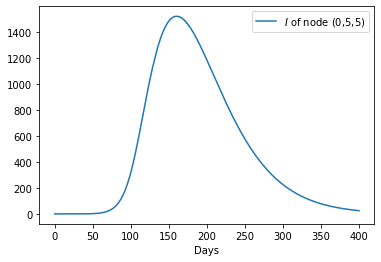

In [6]:
age = 0
model_class = 3
home = 5
loc = 5

model_classes = ['S', 'E', 'A', 'I', 'R']
t_days = ts_saved / (24*60)

plt.plot(t_days, X_states_saved[:, node_mappings[age,model_class,home,loc]],
         label="$%s$ of node (%s,%s,%s)" % ( model_classes[model_class], age, home, loc ) )
plt.xlabel('Days')
plt.legend(loc='upper right', fontsize=10)

plt.show()

Here we see the evolution of the $I$ class of residents of location 5, who are currently at location 5, and are of age group 0. Note the lack of oscillations in the curve, this is because the $I$ class is forbidden to commute. If you set `model_class=2` you will see oscillations in the curve.

`cnode_mappings` is a dictionary that maps each commuter node to its corresponding index in the system state vector. Each key is a tuple of the form `(age, model_class, home, from, to)`. Let's consider the commute of residents of 6, of age-group 2 and class $S$, going from location 6 to 1. This is the commuter node $(\alpha = 2,\ i=6,\ (j=6)\to (k=1))$.

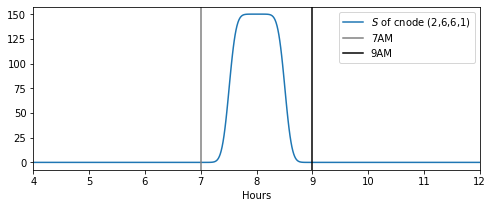

In [7]:
age = 2
model_class = 0
home = 6
fro = 6
to = 1

t_hours = ts_saved / (60)

plt.figure( figsize=(8,3) )
plt.plot(t_hours, X_states_saved[:, cnode_mappings[age,model_class,home,fro,to]],
         label="$%s$ of cnode (%s,%s,%s,%s)" % ( model_classes[model_class], age, home, fro, to ) )
plt.axvline(7, color='gray', label='7AM')
plt.axvline(9, color='black', label='9AM')

plt.xlabel('Hours')
plt.xlim(4, 12)
plt.legend(loc='upper right', fontsize=10)

plt.show()

As can be seen from the above, all simulation output is encoded in `sim_data = ((node_mappings, cnode_mappings), ts_saved, X_states_saved)`. Next, we will introduce some helpful utility functions to present the simulation data in more usable forms.

## 2.3 Manipulating simulation data using `pyrossgeo.utils`

#### `pyrossgeo.utils.extract_network_data`

Returns the values of all epidemiological classes, for each age-group, summed over all nodes and commuter nodes. The output `network_data` has the shape `(len(ts_saved), age_groups, model_dimension)`.

`network_data[tn, a, o]` is equal to the number of people who are $O$, and are of age-group $\alpha$, at time $t_n$. In other words, it is equal to

$$
\sum_{ij} O_{ij}^{\alpha}(t_n) + \sum_{ijk} O_{i(j\to k)}^{\alpha}(t_n)
$$

where $O \in \{ S, E, A, I, R \}$.

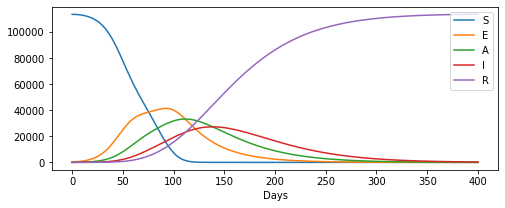

In [8]:
# Plot the evolution of the network as a whole

network_data = pyrossgeo.utils.extract_network_data(sim_data)

plt.figure( figsize=(8,3) )
ts_days = ts_saved / (24*60)

S = np.sum(network_data[:,:,0], axis=1) # Sum over all age-groups
E = np.sum(network_data[:,:,1], axis=1)
A = np.sum(network_data[:,:,2], axis=1)
I = np.sum(network_data[:,:,3], axis=1)
R = np.sum(network_data[:,:,4], axis=1)

plt.plot(ts_days, S, label="S")
plt.plot(ts_days, E, label="E")
plt.plot(ts_days, A, label="A")
plt.plot(ts_days, I, label="I")
plt.plot(ts_days, R, label="R")

plt.legend(loc='upper right', fontsize=10)
plt.xlabel('Days')
plt.show()

#### `pyrossgeo.utils.extract_location_data`

Returns the values of all epidemiological classes, for each age-group, for all locations in the network. The output `location_data` has the shape `(len(ts_saved), age_groups, model_dimension, location)`.

`location_data[tn, a, o, i]` is equal to the number of people who are $O$, and are of age-group $\alpha$, at time $t_n$, summed over all nodes located at $i$. In other words, it is equal to

$$
\sum_i O_{ij}^{\alpha}(t_n)
$$

where $O \in \{ S, E, A, I, R \}$.

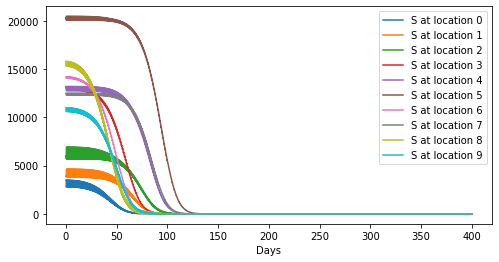

In [9]:
# Plot a specific model class, summed over age groups, for every location

location_data = pyrossgeo.utils.extract_location_data(sim_data)

plt.figure( figsize=(8,4) )
ts_days = ts_saved / (24*60)

model_class = 0
skip = 1

for loc in range(location_data.shape[3]):
    O = np.sum(location_data[:,:,model_class,loc], axis=1) # Sum over all age-groups
    plt.plot(ts_days[::skip], O[::skip], label="%s at location %s" % (model_classes[model_class], loc))

plt.legend(loc='upper right', fontsize=10)
plt.xlabel('Days')
plt.show()

#### `pyrossgeo.utils.extract_community_data`

Returns the values of all epidemiological classes, for each age-group, for all communities in the network. The output `community_data` has the shape `(len(ts_saved), age_groups, model_dimension, communities)`.

`community_data[tn, a, o, i]` is equal to the number of people who are $O$, and are of age-group $\alpha$, at time $t_n$, who live at $i$. In other words, it is equal to

$$
\sum_j O_{ij}^{\alpha}(t_n) + \sum_{jk} O_{i(j\to k)}^{\alpha}(t_n)
$$

where $O \in \{ S, E, A, I, R \}$.

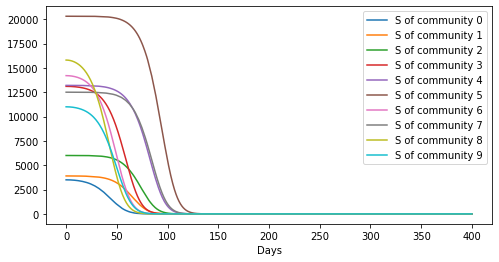

In [10]:
# Plot a specific model class, summed over age groups, for every community

community_data = pyrossgeo.utils.extract_community_data(sim_data)

plt.figure( figsize=(8,4) )
ts_days = ts_saved / (24*60)

model_class = 0

for home in range(community_data.shape[3]):
    O = np.sum(community_data[:,:,model_class,home], axis=1) # Sum over all age-groups
    plt.plot(ts_days, O, label="%s of community %s" % (model_classes[model_class], home))

plt.legend(loc='upper right', fontsize=10)
plt.xlabel('Days')
plt.show()

#### `pyrossgeo.utils.extract_node_data`

Returns the values of all epidemiological classes, for each age-group, for all nodes in the network. The output `node_data` is a dictionary with keys of the form `(home, location)`. Each value in the dictionary is an array of shape `(len(ts_saved), age_groups, model_dimension)`.

`node_data[i,j][tn, a, o]` is equal to the number of people who are $O$ in node $(\alpha, i ,j)$. In other words, it is equal to

$$
O_{ij}^{\alpha}(t_n)
$$

where $O \in \{ S, E, A, I, R \}$.

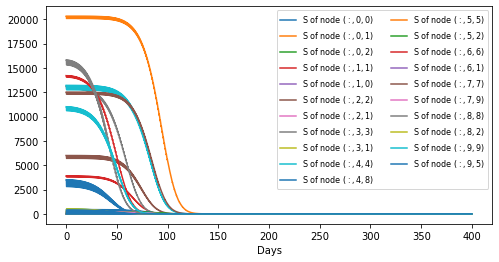

In [11]:
# Plot a specific model class, summed over age groups, for every node

node_data = pyrossgeo.utils.extract_node_data(sim_data)

plt.figure( figsize=(8,4) )
ts_days = ts_saved / (24*60)

model_class = 0

for home, loc in node_data:
    O = np.sum(node_data[home,loc][:,:,model_class], axis=1) # Sum over all age-groups
    plt.plot(ts_days, O, label=r"%s of node $(:, %s,%s)$" % (model_classes[model_class], home, loc))

plt.legend(loc='upper right', fontsize=8, ncol=2)
plt.xlabel('Days')
plt.show()

#### `pyrossgeo.utils.extract_cnode_data`

Returns the values of all epidemiological classes, for each age-group, for all commuter nodes in the network. The output `cnode_data` is a dictionary with keys of the form `(home, from, to)`. Each value in the dictionary is an array of shape `(len(ts_saved), age_groups, model_dimension)`.

`cnode_data[i,j,k][tn, a, o]` is equal to the number of people who are $O$ in the commuter node $(\alpha, i, j \to k)$. In other words, it is equal to

$$
O_{i(j\to k)}^{\alpha}(t_n)
$$

where $O \in \{ S, E, A, I, R \}$.

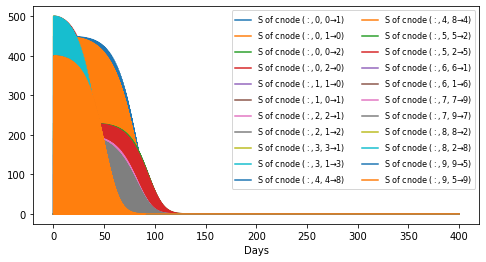

In [12]:
# Plot a specific model class, summed over age groups, for every node

node_data = pyrossgeo.utils.extract_cnode_data(sim_data)

plt.figure( figsize=(8,4) )
ts_days = ts_saved / (24*60)

model_class = 0

for home, fro, to in node_data:
    O = np.sum(node_data[home,fro,to][:,:,model_class], axis=1) # Sum over all age-groups
    plt.plot(ts_days, O, label=r"%s of cnode $(:, %s,%s \to %s)$" % (model_classes[model_class], home, fro, to), alpha=1)

plt.legend(loc='upper right', fontsize=8, ncol=2)
plt.xlabel('Days')
plt.show()

The previous plot isn't very useful. We could instead plot the total number of people commuting at each point in time:

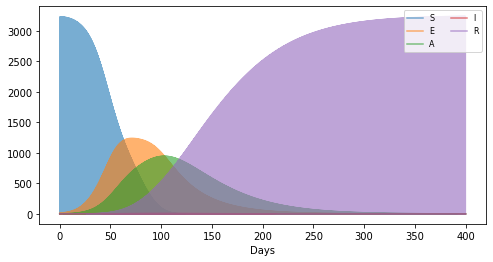

In [13]:
# Plot the total amount of commuting, for a specific model clas

node_data = pyrossgeo.utils.extract_cnode_data(sim_data)

plt.figure( figsize=(8,4) )
ts_days = ts_saved / (24*60)

for model_class in range(len(model_classes)):
    tot_moving = np.zeros( len(ts_saved) )

    for home, fro, to in node_data:
        tot_moving += np.sum(node_data[home,fro,to][:,:,model_class], axis=1)

    plt.plot(ts_days, tot_moving, label=r"%s" % (model_classes[model_class]), alpha=0.6)

plt.legend(loc='upper right', fontsize=8, ncol=2)
plt.xlabel('Days')
plt.show()

Note that the thickness in each curve is due to the oscillations stemming from the commuting patterns (the commuter nodes are only occupied at specific points during the day). If we zoom in, we get:

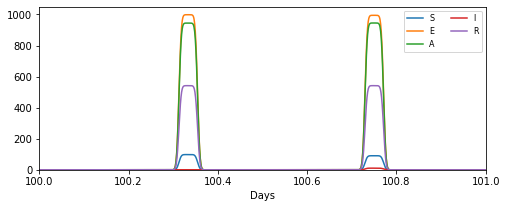

In [14]:
# Plot the total amount of commuting, for a specific model clas

node_data = pyrossgeo.utils.extract_cnode_data(sim_data)

plt.figure( figsize=(8,3) )
ts_days = ts_saved / (24*60)

for model_class in range(len(model_classes)):
    tot_moving = np.zeros( len(ts_saved) )

    for home, fro, to in node_data:
        tot_moving += np.sum(node_data[home,fro,to][:,:,model_class], axis=1)

    plt.plot(ts_days, tot_moving, label=r"%s" % (model_classes[model_class]), alpha=1)

plt.legend(loc='upper right', fontsize=8, ncol=2)
plt.xlabel('Days')
plt.xlim(100, 101)
plt.ylim(0, 1050)
plt.show()

If you observe closely, there seems to be some infecteds $I$ in the second commuting pulse. This is caused by the fact that there are people converting from $E$ to $I$ during the commute.

#### `pyrossgeo.utils.extract_simulation_data`

All of the above can be extracted in one fell swoop using `pyrossgeo.utils.extract_simulation_data`.

In [15]:
ts_saved, node_data, cnode_data, location_data, community_data, network_data = pyrossgeo.utils.extract_simulation_data(sim_data)

## 2.4 Saving simulation data directly to the hard-disk using Zarr

When we ran the simulation in section 2.1, the output was stored in RAM. For very large networks this is unfeasible, so can instead save the output directly to the hard-drive using [Zarr](https://zarr.readthedocs.io/en/stable/).

To enable this feature, we pass `save_path="path/to/output/file"` to `pyrossgeo.Simulation.simulate`.

In [25]:
ts, dts = pyrossgeo.utils.get_dt_schedule([
    (0,  2*60),    
    (7*60,  1),    
    (9*60, 2*60),  
    (17*60, 1),     
    (19*60, 2*60)  
], end_time=24*60)

t_start = 0
t_end = 24*60*400 # Run for 200 days

sim = pyrossgeo.Simulation()
X_state = sim.initialize(sim_config_path='SEAIR_network')

# As storing files on the hard-drive is quite slow, we set `steps_per_save=len(dts)`.
sim_data = sim.simulate(X_state, t_start, t_end, dts, steps_per_save=len(dts), save_path='sim_data')

This creates a folder called `sim_data`, where the contents of the simulation is stored. The return value `sim_data` is of the same form `(state_mappings, ts, X_states)` as discussed in section 2.2, but the array `X_states` is now a `zarr.core.Array`.

To load the simulation data we use `pyrossgeo.utils.load_sim_data`

In [26]:
sim_data = pyrossgeo.utils.load_sim_data('sim_data')

To load `X_states` as a Zarr array, we set `use_zarr=True`.

In [27]:
sim_data = pyrossgeo.utils.load_sim_data('sim_data', use_zarr=True)
(node_mappings, cnode_mappings), ts, X_states = sim_data
print(type(X_states))

<class 'zarr.core.Array'>


Zarr arrays can be used the same way an ordinary numpy array is used, and is compatible with any of the helper functions described in section 2.3. Although because Zarr does not store the array directly RAM, the function calls will be significantly slower. 

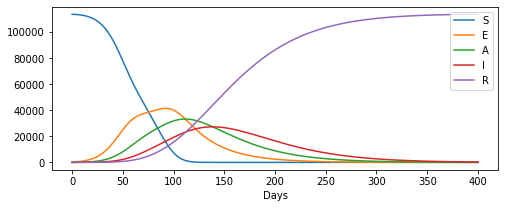

In [28]:
# Plot the evolution of the network as a whole

network_data = pyrossgeo.utils.extract_network_data(sim_data)

plt.figure( figsize=(8,3) )
ts_days = ts / (24*60)

S = np.sum(network_data[:,:,0], axis=1) # Sum over all age-groups
E = np.sum(network_data[:,:,1], axis=1)
A = np.sum(network_data[:,:,2], axis=1)
I = np.sum(network_data[:,:,3], axis=1)
R = np.sum(network_data[:,:,4], axis=1)

plt.plot(ts_days, S, label="S")
plt.plot(ts_days, E, label="E")
plt.plot(ts_days, A, label="A")
plt.plot(ts_days, I, label="I")
plt.plot(ts_days, R, label="R")

plt.legend(loc='upper right', fontsize=10)
plt.xlabel('Days')
plt.show()

This concludes the second part of the PyRossGeo tutorial.

- [Go back to **Tutorial 2: Handling PyRossGeo output**](../tutorial2-handling-PyRossGeo-output/tutorial2-handling-PyRossGeo-output.ipynb)
- [Continue to **Tutorial 4: Making visualisations using GeoPandas**](../tutorial4-making-visualisations-with-geopandas/tutorial4-making-visualisations-using-geopandas.ipynb)
- [Go to the PyRossGeo documentation](https://github.com/lukastk/PyRossGeo/blob/master/docs/documentation.md)